<a href="https://colab.research.google.com/github/alina0195/sketches/blob/main/Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Prereq

In [ ]:
! pip install Unidecode -q


     |████████████████████████████████| 235 kB 20.7 MB/s 


In [ ]:
! pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 30.2 MB/s 


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 37.5 MB/s 
     |████████████████████████████████| 596 kB 72.8 MB/s 
     |████████████████████████████████| 6.6 MB 56.4 MB/s 
     |████████████████████████████████| 86 kB 6.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 10.0 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=e9e29273a75b024b717ef2ff5646277eac64588a9b216c96509b8b76c2af9d27
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tqdm import tqdm
from pandas_profiling import ProfileReport


import torch
import torch.nn.functional as F
import torch.nn as nn

from transformers import AutoTokenizer, AutoModel
from transformers import AdamW, get_linear_schedule_with_warmup


In [ ]:
import json
import re
import random
import time

In [ ]:
import torchmetrics
from torchmetrics.classification import Accuracy

In [ ]:
from emoji import demojize
from nltk.tokenize import TweetTokenizer
import html
import unicodedata
import unidecode
import re

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.utils import class_weight

# Device

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

if torch.cuda.is_available():
  for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))
else:
  print("You are running on CPU")

Tesla T4


In [ ]:
device = torch.device("cpu")

# Config

In [ ]:
class config:
  SEED = 42

  MODEL_CT_BERT_PATH = '/content/drive/MyDrive/models/ctbert_3_cls_corona_4_iunie_v1.pt'
  MODEL_BERT_COV_PATH ='/content/drive/MyDrive/models/bertweet_3_cls_corona_3_iunie_v2.pt'
  MODEL_LR_PATH = '/content/drive/MyDrive/models/LR models/sentiment_coronanlp_lr_1ngram_7793.sav'
  MODEL_SVM_PATH = '/content/drive/MyDrive/models/SVM models/sentiment_svm_v1_1_ngram.sav'
  MODEL_BiLSTM_PATH = '/content/drive/MyDrive/models_bilstm/bilstm1_model'
  MODEL_LSTM_PATH = '/content/drive/MyDrive/models_lstm/model1'

  MAX_LEN_CT_BERT = 96
  MAX_LEN_BERT_COV = 128
  PRE_TRAINED_MODEL_CT_BERT = 'digitalepidemiologylab/covid-twitter-bert-v2'
  PRE_TRAINED_MODEL_BERT_COV = 'vinai/bertweet-covid19-base-uncased'

  DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
import pickle
bertcov_model = torch.load(config.MODEL_BERT_COV_PATH)
ctbert_model = torch.load(config.MODEL_CT_BERT_PATH)

In [ ]:
bertcov_model.to(device)
ctbert_model.to(device)

TweetClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-12, elementw

In [ ]:
file = open(config.MODEL_LR_PATH,'rb')
lr_model = pickle.load(file)
file.close()
file = open(config.MODEL_SVM_PATH,'rb')
svm_model = pickle.load(file)
file.close()

# Read dataframe

In [ ]:
path_train='/content/drive/MyDrive/dataset/Corona_NLP_train.csv'
path_test='/content/drive/MyDrive/dataset/Corona_NLP_test.csv'

In [ ]:
train_df = pd.read_csv(path_test, encoding='ISO-8859-1')
test_df = pd.read_csv(path_train, encoding='ISO-8859-1')

In [ ]:
def check_df(df, target_col):
  df= df.dropna(subset=[target_col])
  df=df.reset_index()
  return df

In [ ]:
print('Training samples: ', len(train_df))
print('Test samples: ', len(test_df))

Training samples:  3798
Test samples:  41157


In [ ]:
def plot_distribution(df, target_col, title):
  distribution = df[target_col].value_counts()
  plt.figure(figsize=(10,4))
  plt.title(title)
  plt.bar(distribution.index, distribution.values)
  plt.show()

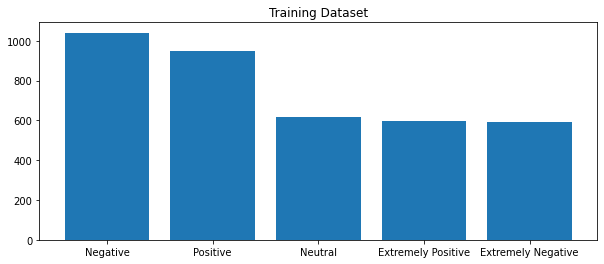

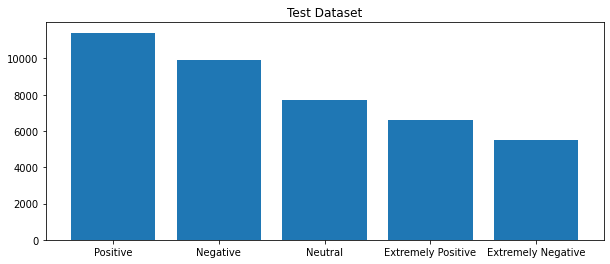

In [ ]:
%matplotlib inline
plot_distribution(train_df,'Sentiment','Training Dataset')
plot_distribution(test_df,'Sentiment','Test Dataset')

In [ ]:
df_train = check_df(train_df,'Sentiment')
df_test = check_df(test_df,'Sentiment')

In [ ]:
print('Training samples: ', len(train_df))
print('Test samples: ', len(test_df))

Training samples:  3798
Test samples:  41157


In [ ]:
pd.set_option("display.max_columns", None)

In [ ]:
train_df  = train_df[~train_df.duplicated(subset=['OriginalTweet'])==True]

In [ ]:
test_df = test_df[~test_df.duplicated(subset=['OriginalTweet'])==True]

In [ ]:
df_all = pd.concat((train_df, test_df), ignore_index=True)
print(df_all[~df_all.duplicated(subset=['OriginalTweet'])==True])
print(len(df_all))

       UserName  ScreenName                      Location     TweetAt  \
0             1       44953                           NYC  02-03-2020   
1             2       44954                   Seattle, WA  02-03-2020   
2             3       44955                           NaN  02-03-2020   
3             4       44956                   Chicagoland  02-03-2020   
4             5       44957           Melbourne, Victoria  03-03-2020   
...         ...         ...                           ...         ...   
44950     44951       89903  Wellington City, New Zealand  14-04-2020   
44951     44952       89904                           NaN  14-04-2020   
44952     44953       89905                           NaN  14-04-2020   
44953     44954       89906                           NaN  14-04-2020   
44954     44955       89907  i love you so much || he/him  14-04-2020   

                                           OriginalTweet           Sentiment  
0      TRENDING: New Yorkers encounter empty

In [ ]:
df_all = df_all.sample(frac=1).reset_index(drop=True)
print('Samples:',len(df_all))

df_all.drop(['ScreenName'], inplace=True, axis=1)
df_all.drop(['Location'], inplace=True, axis=1)
df_all.drop(['TweetAt'], inplace=True, axis=1)
df_all.drop(['UserName'], inplace=True, axis=1)

Samples: 44955


In [ ]:
df_train, df_val = train_test_split(df_train, test_size = 0.1)

In [ ]:
print("Train Samples:",len(df_train),"\nValidation Samples:", len(df_val), "\nTest Samples:", len(df_test))

Train Samples: 3418 
Validation Samples: 380 
Test Samples: 41157


In [ ]:
df_test.sample(5)

,index,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
30970,30970,34769,79721,"San Antonio, TX",06-04-2020,People out here acting like itÂs Black Friday...,Positive
6038,6038,9837,54789,The Internet,19-03-2020,Dumbass roommate doen't understand the differe...,Negative
22205,22205,26004,70956,Rossendale,25-03-2020,The supermarket jobs available in Lancashire n...,Extremely Negative
29327,29327,33126,78078,"Dhamtari,Raipur,india.",05-04-2020,Non surgical Mask by to standard and specifica...,Positive
2398,2398,6197,51149,"Owerri, Imo State Nigeria",17-03-2020,Canadians Âdo not need to panicÂ about food ...,Positive


In [ ]:
df_train.sample(5)

,index,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
2281,2281,2282,47234,Canada,14-03-2020,Minister of Health and Minister of Agriculture...,Extremely Negative
855,855,856,45808,"Mystic Marsh, Winter Tundra",12-03-2020,"Lidl is total chaos, queues as long as the ais...",Extremely Negative
1488,1488,1489,46441,akyem anyinam,13-03-2020,@jeffwellz For hand sanitizers in bulk purchas...,Positive
2611,2611,2612,47564,NaN,14-03-2020,It sucks that ppl have to TELL ppl not to stoc...,Extremely Negative
374,374,375,45327,"BozÃ¼yÃ¼k, TÃ¼rkiye",12-03-2020,After the had reported of COVID-19 infection i...,Extremely Positive


In [ ]:
df_train

,index,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
1539,1539,1540,46492,"Calgary, Alberta",13-03-2020,Real Canadian Superstore online shopping also ...,Negative
1262,1262,1263,46215,"St Petersburg, FL",13-03-2020,Seeing all these grocery store stories answers...,Extremely Negative
1203,1203,1204,46156,"South-West Oxford, Ontario",13-03-2020,The #Trudeau government shunned resource devel...,Negative
1595,1595,1596,46548,Cyprus,13-03-2020,"Stocked up on cleaning supply, desinfectants a...",Positive
2744,2744,2745,47697,"Amsterdam, The Netherlands",14-03-2020,Something I'm not seeing run out in supermarke...,Negative
...,...,...,...,...,...,...,...
3437,3437,3438,48390,"Washington, DC",16-03-2020,The supermarket business is booming! #COVID2019,Neutral
543,543,544,45496,NaN,12-03-2020,Frozen food demand surges amid Covid-19 scare ...,Negative
1172,1172,1173,46125,NaN,13-03-2020,Q: Should stocks be worth less today than they...,Negative
1048,1048,1049,46001,nyc,13-03-2020,Since last weekÂs reporting of the impact of ...,Neutral


Verific daca cele 2 dataframe-uri au instante comune

In [ ]:
print(pd.merge(df_train, df_test, how='inner', on=['OriginalTweet']))
print(pd.merge(df_train, df_val, how='inner', on=['OriginalTweet']))
print(pd.merge(df_val, df_test, how='inner', on=['OriginalTweet']))

Empty DataFrame
Columns: [index_x, UserName_x, ScreenName_x, Location_x, TweetAt_x, OriginalTweet, Sentiment_x, index_y, UserName_y, ScreenName_y, Location_y, TweetAt_y, Sentiment_y]
Index: []
Empty DataFrame
Columns: [index_x, UserName_x, ScreenName_x, Location_x, TweetAt_x, OriginalTweet, Sentiment_x, index_y, UserName_y, ScreenName_y, Location_y, TweetAt_y, Sentiment_y]
Index: []
Empty DataFrame
Columns: [index_x, UserName_x, ScreenName_x, Location_x, TweetAt_x, OriginalTweet, Sentiment_x, index_y, UserName_y, ScreenName_y, Location_y, TweetAt_y, Sentiment_y]
Index: []


In [ ]:
def assign_new_label(x):
  if x=='Extremely Negative' or x=='negative ':
    x='Negative'
  if x=='Extremely Positive' or x=='Extremly Positive':
    x='Positive'
  return x

In [ ]:
df_train['target'] = df_train['Sentiment'].apply(lambda x: assign_new_label(x))
df_test['target'] = df_test['Sentiment'].apply(lambda x: assign_new_label(x))
df_val['target'] = df_val['Sentiment'].apply(lambda x: assign_new_label(x))

In [ ]:
df_train = df_train.dropna(subset=['target'])
df_test = df_test.dropna(subset=['target'])
df_val = df_val.dropna(subset=['target'])

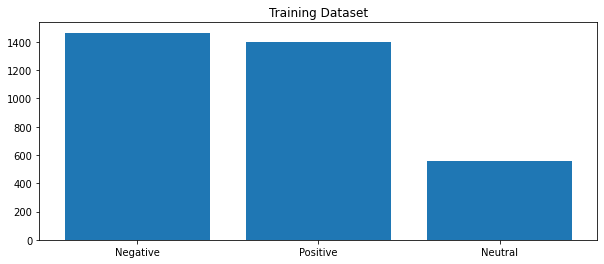

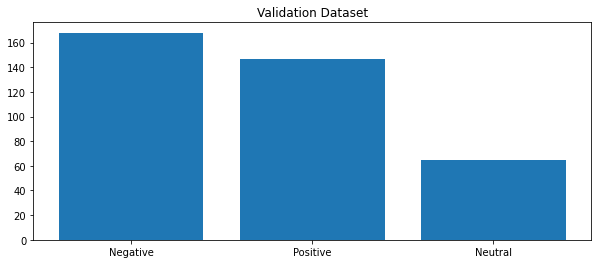

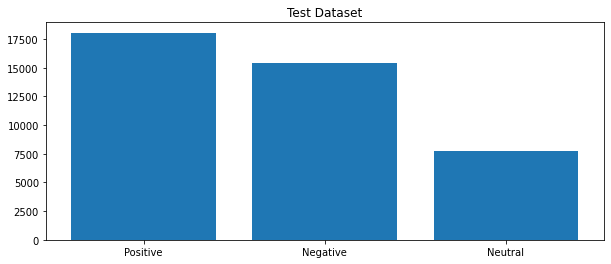

In [ ]:
%matplotlib inline
plot_distribution(df_train,'target','Training Dataset')
plot_distribution(df_val,'target','Validation Dataset')
plot_distribution(df_test,'target','Test Dataset')

In [ ]:
np_labels = np.array(df_train.target.tolist())
classes = np.unique(np_labels)
classes

array(['Negative', 'Neutral', 'Positive'], dtype='<U8')

In [ ]:
df_train= df_train.dropna(subset=['target'])
df_test= df_test.dropna(subset=['target'])
df_val= df_val.dropna(subset=['target'])

# Data preparation

###TweetTokenizer for BERT like model

In [ ]:
tokenizer = TweetTokenizer()
""" Bert proposed method to cleanup dataset"""

""" Added characters “”–-‘’ """
def normalizeToken(token):
    lowercased_token = token.lower()

    if token.startswith("@"):
        return "@USER"
    elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
        return "HTTPURL"
    elif len(token) == 1:
        return demojize(token)
    else:
        if token == "‘" or token=='’':
            return "'"
        elif token == "…":
            return "..."
        elif token == "“" or token=="”":
            return "\""
        elif token == "–-":
            return "--"
        else:
            return token

""" Added control_char_regex | html.unscape | unicode.decode """
def normalizeTweet(tweet):
    tokens = tokenizer.tokenize(tweet.replace("’", "'").replace("…", "..."))
    normTweet = " ".join([normalizeToken(token) for token in tokens])
    control_char_regex = re.compile(r'[\r\n\t]+')
    normTweet = re.sub(control_char_regex, ' ', normTweet)
    normTweet = html.unescape(normTweet)
    normTweet = unidecode.unidecode(normTweet)

    normTweet = (
        normTweet.replace("cannot ", "can not ")
        .replace("n't ", " n't ")
        .replace("n 't ", " n't ")
        .replace("ca n't", "can't")
        .replace("ai n't", "ain't")
    )
    normTweet = (
        normTweet.replace("'m ", " 'm ")
        .replace("'re ", " 're ")
        .replace("'s ", " 's ")
        .replace("'ll ", " 'll ")
        .replace("'d ", " 'd ")
        .replace("'ve ", " 've ")
    )
    normTweet = (
        normTweet.replace(" p . m .", "  p.m.")
        .replace(" p . m ", " p.m ")
        .replace(" a . m .", " a.m.")
        .replace(" a . m ", " a.m ")
    )

    return " ".join(normTweet.split())


In [ ]:
print(
  normalizeTweet(
      "SC has first two presumptive cases of coronavirus #COVIDIsEverywhere, DHEC confirms https://postandcourier.com/health/covid19/sc-has-first-two-presumptive-cases-of-coronavirus-dhec-confirms/article_bddfe4ae-5fd3-11ea-9ce4-5f495366cee6.html?utm_medium=social&utm_source=twitter&utm_campaign=user-share… via @postandcourier"
  )
)

SC has first two presumptive cases of coronavirus #COVIDIsEverywhere , DHEC confirms HTTPURL ... via @USER


In [ ]:
df_train['final'] = df_train['OriginalTweet'].apply(lambda x: normalizeTweet(x))
df_test['final'] = df_test['OriginalTweet'].apply(lambda x: normalizeTweet(x))
df_val['final'] = df_val['OriginalTweet'].apply(lambda x: normalizeTweet(x))

In [ ]:
df_val[:1][['OriginalTweet','final']]

,OriginalTweet,final
113,I donÂt understand the run on toilet paper. \...,I donA t understand the run on toilet paper . ...


In [ ]:
df_test= df_test.dropna(subset=['final'])
df_train= df_train.dropna(subset=['final'])
df_val= df_val.dropna(subset=['final'])

In [ ]:
print(len(df_test),len(df_train), len(df_val))

41157 3418 380


### Clean FOR OTHER MODELS THAN BERT

In [ ]:
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.remove('not')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!pip install wordsegment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.8 MB 35.1 MB/s 


In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
from wordsegment import load, segment
from nltk import RegexpTokenizer, TweetTokenizer, word_tokenize
import re

In [ ]:
def lemmatize_on_text(data):
    lm = nltk.WordNetLemmatizer() 
    text = [lm.lemmatize(word) for word in data]
    return data

In [ ]:
def clean_dataframe(df, col_name):
  corpus = []

  stop_words = stopwords.words('english')
  stop_words.remove('not')

  # Load segmentation dictionary
  load()

  for i in range(0, len(df)):
    text = df[col_name].iloc[i] 
    text = re.sub("'", "", text)  # avoid removing contractions in english
    text = text.lower()

    text = re.sub("#[A-Za-z0-9_]+", "", text)  # remove hashtags
    text = re.sub("@[A-Za-z0-9_]+", "", text)  # remove mentions
    text = re.sub(r"http\S+", "", text) # remove links
    text = re.sub(r"www.\S+", "", text) # remove URLs

    tk = TweetTokenizer(reduce_len=True) # tokenize tweet
    text = tk.tokenize(text)

    text = [word for word in text if not word in stop_words]  # remove common words
    text = ' '.join(text)
    
    text = re.sub("[^a-z]", " ", text)  # remove symbols other than letters
    text = re.sub(r'\b\w{1,2}\b', '', text)  # remove words from 1 or 2 letters

    text = lemmatize_on_text(text)  # perform lemmatization
    text = re.sub(' +', ' ', text)
    corpus.append(text)
  
  return corpus

In [ ]:
corpus_test = clean_dataframe(df_test,'OriginalTweet')

In [ ]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [ ]:
corpus_train = clean_dataframe(df_train, 'OriginalTweet')

In [ ]:
df_test['final_for_others'] = corpus_test
df_train['final_for_others'] = corpus_train

In [ ]:
df_test.head()

,index,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,target,final,final_for_others
0,0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,Neutral,@USER @USER @USER HTTPURL and HTTPURL and HTTPURL,
1,1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,Positive,advice Talk to your neighbours family to excha...,advice talk neighbours family exchange phone n...
2,2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,Positive,Coronavirus Australia : Woolworths to give eld...,coronavirus australia woolworths give elderly ...
3,3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,Positive,My food stock is not the only one which is emp...,food stock not one empty please dont panic eno...
4,4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,Negative,"Me , ready to go at supermarket during the #CO...",ready supermarket outbreak not paranoid food ...


###BERT Tokenizer

In [ ]:
print(config.PRE_TRAINED_MODEL_BERT_COV)
print(config.PRE_TRAINED_MODEL_CT_BERT)

vinai/bertweet-covid19-base-uncased
digitalepidemiologylab/covid-twitter-bert-v2


In [ ]:
bert_tokenizer_ctbert = AutoTokenizer.from_pretrained(config.PRE_TRAINED_MODEL_CT_BERT,normalization=True, use_fast=False)
bert_tokenizer_bertcov = AutoTokenizer.from_pretrained(config.PRE_TRAINED_MODEL_BERT_COV,normalization=True, use_fast=False)

Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/421 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/824k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def tokenize_function_bertcov(text):
  tok = bert_tokenizer_bertcov(text  
                       ,add_special_tokens=True, 
                       padding="max_length",  
                       max_length = config.MAX_LEN_BERT_COV,
                       truncation=True,   
                       return_tensors="pt" 
                       )
  return tok['input_ids'], tok['attention_mask']

def tokenize_function_ctbert(text):
  tok = bert_tokenizer_ctbert(text  
                       ,add_special_tokens=True, 
                       padding="max_length",  
                       max_length = config.MAX_LEN_CT_BERT,
                       truncation=True,   
                       return_tensors="pt" 
                       )
  return tok['input_ids'], tok['attention_mask']

### Download BERT pre-trained model

In [ ]:
bertweet_cov = AutoModel.from_pretrained(config.PRE_TRAINED_MODEL_BERT_COV)
ctbert = AutoModel.from_pretrained(config.PRE_TRAINED_MODEL_CT_BERT)

Some weights of the model checkpoint at vinai/bertweet-covid19-base-uncased were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of the model checkpoint at digitalepidemiologylab/covid-twitter-bert-v2 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# BERT MODELS CLASSES

In [ ]:
# Link: https://skimai.com/fine-tuning-bert-for-sentiment-analysis/ 

%%time

class TweetClassifier(nn.Module):
    """Bert Model for Classification Tasks."""

    def __init__(self, bertModel, out_feat, freeze_bert=False):
        """
        @param    bertModel: a BertModel object
        @param    out_feat: number of classes
        """
        super().__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = bertModel.config.hidden_size, 50, out_feat

        # Instantiate BERT model
        self.bert = bertModel

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in,H),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(H, D_out),
            nn.Softmax(dim=1)
        )

        # Freeze the pre-trained layers of BERT model
        if freeze_bert:
          for param in self.bert.parameters():
            param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask )

        # Extract the last hidden state of the token `[CLS]` for classification task ---- https://www.tensorflow.org/text/tutorials/classify_text_with_bert
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 25 µs, sys: 3 µs, total: 28 µs
Wall time: 31.5 µs


# Ensemble

In [ ]:
!python --version

Python 3.7.13


In [ ]:
df_test

,index,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,target,final,final_for_others
0,0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,Neutral,@USER @USER @USER HTTPURL and HTTPURL and HTTPURL,
1,1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,Positive,advice Talk to your neighbours family to excha...,advice talk neighbours family exchange phone n...
2,2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,Positive,Coronavirus Australia : Woolworths to give eld...,coronavirus australia woolworths give elderly ...
3,3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,Positive,My food stock is not the only one which is emp...,food stock not one empty please dont panic eno...
4,4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,Negative,"Me , ready to go at supermarket during the #CO...",ready supermarket outbreak not paranoid food ...
...,...,...,...,...,...,...,...,...,...,...
41152,41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral,Neutral,Airline pilots offering to stock supermarket s...,airline pilots offering stock supermarket shel...
41153,41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative,Negative,Response to complaint not provided citing COVI...,response complaint not provided citing covid r...
41154,41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive,Positive,You know itA s getting tough when @USER is rat...,know getting tough rationing toilet paper mart...
41155,41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral,Neutral,Is it wrong that the smell of hand sanitizer i...,wrong smell hand sanitizer starting turn


In [ ]:
import torch.nn.functional as F

def predict(text,model, model_name,device):
  if model_name == 'ct_bert':
    input_ids, mask = tokenize_function_ctbert(text)
    tensor_prediction = model(input_ids,mask)
    final_tensor = F.softmax(tensor_prediction,dim=1)
    tensor = final_tensor.tolist()[0]
    return tensor
  elif model_name == 'bertcov':
    input_ids, mask = tokenize_function_bertcov(text)
    tensor_prediction = model(input_ids,mask)
    final_tensor = F.softmax(tensor_prediction,dim=1)
    tensor = final_tensor.tolist()[0]
    return tensor
  elif model_name == 'lr':
    pass
  elif model_name == 'svm':
    pass

In [ ]:
text = df_test.iloc[2]['final']

In [ ]:
print('BERT COV ', predict(text, bertcov_model, 'bertcov',device))
print('CT BERT ', predict(text, ctbert_model, 'ct_bert',device))

BERT COV  [0.2119530290365219, 0.2119499295949936, 0.5760970711708069]
CT BERT  [0.21194155514240265, 0.21194155514240265, 0.5761168599128723]


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
text_transformer = TfidfVectorizer(stop_words='english', lowercase=True)
text_transformer.fit(df_train.final_for_others)
x_test_lr = text_transformer.transform(df_test.final_for_others)

### ensemble class

In [ ]:
class Ensemble_Model:
  def __init__(self, bert_cov,ctbert, svm_model, lr_model,bilstm_model):
    self._bert_model = bert_cov
    self._ctbert = ctbert
    self._bilstm_model = bilstm_model
    self._svm_model = svm_model
    self._lr_model  = lr_model
  
  def set_bert_device(self, device):
    self._bert_model.set_device(device)

  def predict(self, texts):
    svm_predictions = ''
    bertcov_predictions = ''
    ctbert_predictions = ''
    lr_predictions = ''
    bilstm_predictions = '' 
    predictions = svm_predictions + bertcov_predictions + ctbert_predictions + lr_predictions + bilstm_predictions
    return predictions